In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from jaqalpaq import run
from jaqalpaq import emulator
from jaqalpaq.run import run_jaqal_file, run_jaqal_string, run_jaqal_batch, run_jaqal_circuit, frontend
# from jaqalpaq.run import * (identical to from jaqalpaq import run aside from needing "run" before everything)
# from jaqalpaq.run import frontend (needed to switch between emulator and experiment)
from jaqalpaq.parser import parse_jaqal_string

# From Website

In [2]:
 num_qubits = 2
num_states = 1<<num_qubits

In [3]:
#Create a jaqal code (string method)

jaqal_code = f"""
//Comment via a double forward slash in jaqal strings

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha 0.1701
let beta 0.1701
let gamma 0.72405
let delta 0.74656
let epsilon 0.01
let zeta 0.1031
let eta 0.82893
let theta 0.75567
let iota 0.76884
let kappa 0.1701

let num_loops 0
let pi_4 {np.pi/4}

//Select your register of qubits
register q[{num_qubits}]

//Create jaqal circuit, starting with prepare_all, ending with measure_all
prepare_all
<R q[0] alpha beta | R q[1] gamma delta>
<Rz q[0] epsilon | Rz q[1] zeta>
MS q[0] q[1] eta theta
R q[0] iota kappa
loop num_loops {{
    MS q[0] q[1] 0 pi_4}}
measure_all
"""

In [4]:
#Define series of arrays for an 'override' dictionary
angles = list(np.linspace(-np.pi/2,np.pi/2, 21))
thetas = [np.pi/2-abs(a) for a in angles]
loops = list(range(0,21))

#Define a python dictionary to be the override dictionary
#We can override any and/or all let parameters. Caveat: All elements of the dictionary must be the same length array OR a scalar
override_dict={ "alpha":   angles,
                "beta":    angles,
                "gamma":   angles,
                "delta":   angles,
                "epsilon": angles,
                "zeta":    angles,
                "eta":     angles,
                "theta":   thetas,
                "iota":    angles,
                "kappa":   angles,
                "num_loops": loops,
                "__repeats__": 2000}

#Run the circuit with the parameters being overwritten
res = run_jaqal_string(jaqal_code, overrides=override_dict)

#The result object that is returned has quite a lot of information stored in it.
#This object contains the data sorted by each instance of the override dictionary, known as a subbatch
#This subbatch is then further divided into subcircuits (if we had any). If not, just use .by_subcircuit[0]
#We can then call for the probability sorted by the integer of the binary representation of the qubit states
print("PROBABILITIES ORDERED BY QUBIT INTEGER VALUE")
for i in range(len(angles)):
    print(res.by_subbatch[i].by_subcircuit[0].simulated_probabilities.by_int_dense) #absolute probability
    print(res.by_subbatch[i].by_subcircuit[0].normalized_counts.by_int_dense) #with simulated shot noise
    
#We can also sort the resulting probabilities by their string representation (matrix/ket ordering)
print("PROBABILITIES ORDERED BY QUBIT STRING REPRESENTATION")
for i in range(len(angles)):
    print(res.by_subbatch[i].by_subcircuit[0].simulated_probabilities.by_str_dense) #absolute probability
    print(res.by_subbatch[i].by_subcircuit[0].normalized_counts.by_str_dense) #with simulated shot noise

PROBABILITIES ORDERED BY QUBIT INTEGER VALUE
[[0.25]
 [0.25]
 [0.25]
 [0.25]]
[[0.248]
 [0.248]
 [0.249]
 [0.255]]
[[0.15521143]
 [0.29205858]
 [0.21796375]
 [0.33476625]]
[[0.1545]
 [0.282 ]
 [0.2245]
 [0.339 ]]
[[0.0219206 ]
 [0.20659587]
 [0.32183631]
 [0.44964721]]
[[0.026 ]
 [0.1945]
 [0.335 ]
 [0.4445]]
[[0.00710145]
 [0.11161837]
 [0.42340979]
 [0.45787039]]
[[0.01  ]
 [0.12  ]
 [0.4215]
 [0.4485]]
[[0.01493425]
 [0.15583128]
 [0.35569488]
 [0.47353959]]
[[0.0125]
 [0.1475]
 [0.3655]
 [0.4745]]
[[0.05334709]
 [0.26830583]
 [0.17991748]
 [0.49842961]]
[[0.049 ]
 [0.2625]
 [0.1775]
 [0.511 ]]
[[0.31000929]
 [0.28146769]
 [0.06684163]
 [0.3416814 ]]
[[0.302]
 [0.295]
 [0.071]
 [0.332]]
[[0.63382386]
 [0.17508098]
 [0.05305083]
 [0.13804433]]
[[0.645 ]
 [0.1675]
 [0.0505]
 [0.137 ]]
[[0.59949211]
 [0.06079955]
 [0.05226754]
 [0.28744081]]
[[0.6065]
 [0.0585]
 [0.0455]
 [0.2895]]
[[0.22137474]
 [0.00899478]
 [0.02118271]
 [0.74844777]]
[[0.2165]
 [0.0105]
 [0.02  ]
 [0.753 ]]
[[0.]
 

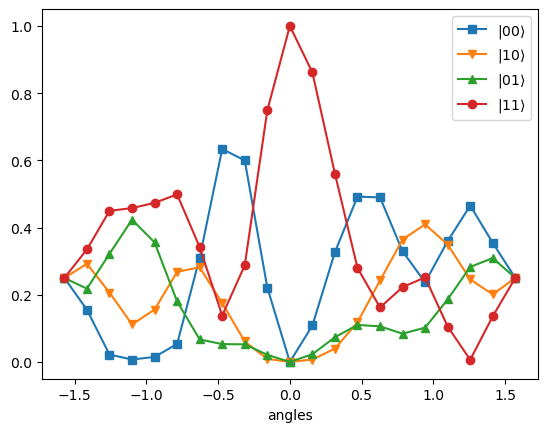

In [5]:
#Plot the results
outcomes = [[] for _ in range(num_states)]
for r in res.by_subbatch:
    for n in range(num_states):
        outcomes[n].append(r.by_subcircuit[0].simulated_probabilities.by_int_dense[n])

plt.figure(1)        
for n in range(num_states):
    plt.plot(angles, 
             outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:02b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
plt.legend()
plt.xlabel("angles");

# Rabi Oscillations

In [6]:
num_qubits = 2
num_states = 1<<num_qubits

In [27]:
#Create a jaqal code (string method)

jaqal_code = f"""
//Comment via a double forward slash in jaqal strings

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha 0.1

//Select your register of qubits
register q[{num_qubits}]

//Create jaqal circuit, starting with prepare_all, ending with measure_all
prepare_all
Rx q[0] alpha
measure_all
"""

In [30]:
#Define series of arrays for an 'override' dictionary
angles = list(np.linspace(-np.pi/2,np.pi/2, 21))
thetas = [np.pi/2-abs(a) for a in angles]

#Define a python dictionary to be the override dictionary
#We can override any and/or all let parameters. Caveat: All elements of the dictionary must be the same length array OR a scalar
override_dict={ "alpha":   angles,
                "__repeats__": 2000}

#Run the circuit with the parameters being overwritten
res = run_jaqal_string(jaqal_code, overrides=override_dict)

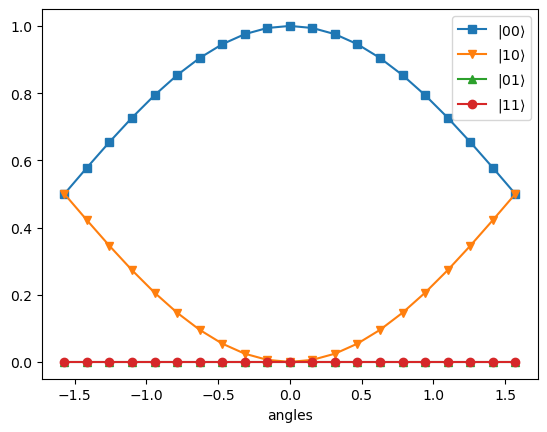

In [29]:
#Plot the results
outcomes = [[] for _ in range(num_states)]
for r in res.by_subbatch:
    for n in range(num_states):
        outcomes[n].append(r.by_subcircuit[0].simulated_probabilities.by_int_dense[n])

plt.figure(1)        
for n in range(num_states):
    plt.plot(angles, 
             outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:02b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
plt.legend()
plt.xlabel("angles");